# Import Libraries and Load Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import networkx as nx

from bokeh.io import show, output_notebook
from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool, TapTool, BoxSelectTool
from bokeh.models.graphs import from_networkx, NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.palettes import Spectral4
from mpl_toolkits import mplot3d

In [2]:
orders = pd.read_csv('../dataset/orders.csv')
products = pd.read_csv('../dataset/products.csv')
category = pd.read_csv('../dataset/departments.csv')
aisle = pd.read_csv('../dataset/aisles.csv')
ordered_products = pd.read_csv('../dataset/order_products_prior.csv')

# Merging all csv into one dataframe

Understanding the dataset which we have, will proceed to merge the dataframes in accordance to the respective secondary keys then perform cleaning and EDA

In [3]:
def merge_dataframe(df1, df2, on_column):
    df = pd.merge(df1, df2, how = 'left', on = on_column)
    return df

In [4]:
product_with_category = merge_dataframe(products, category, 'department_id')

In [5]:
product_with_category_aisle = merge_dataframe(product_with_category, aisle, 'aisle_id')

In [6]:
ordered_product_full = merge_dataframe(ordered_products, product_with_category_aisle, 'product_id')

In [7]:
full_df = merge_dataframe(orders, ordered_product_full, 'order_id')

# Check and Clean Final DataFrame

In [8]:
full_df.shape

(32640698, 15)

We have over 3 million rows and 15 columns, we will go through the columns one by one. Before doing that, we will define a function to prints out the basic information for the column and decide if there is a need to explore more on the respective columns after these information are printed out.

In [9]:
def check_column(df, column, print_unique = False):
    print('{} has {} values'.format(column, df[column].count()))
    print('{} has {} unique values'.format(column, df[column].nunique()))
    print('{} has {} null values'.format(column, df[column].isnull().sum()))
    print('{} data type is {}'.format(column, df[column].dtypes))
    if print_unique == True:
        print("{}'s unique value are \n {}".format(column, df[column].unique()))

## Order ID

Order ID shows the ID of the orders placed, each order will have a unique order ID

In [10]:
check_column(full_df, 'order_id')

order_id has 32640698 values
order_id has 3421083 unique values
order_id has 0 null values
order_id data type is int64


- We have over 3421083 unique orders, we have an adequate number of orders to build our recommender system. 
- There are no null values and the data type is correct

## User ID

User ID shows the ID of the users, each user will have a unique order ID

In [11]:
check_column(full_df, 'user_id')

user_id has 32640698 values
user_id has 206209 unique values
user_id has 0 null values
user_id data type is int64


- We have 206209 unique users, which is adequate to build our recommender system
- There are no null values and data type is correct

## Eval Set

Evaluation set is the label detailing if where the data belongs to the test, train or prior set. This is for the kaggle competition and we do not need this for this project. Nevertheless, we will perform a check on this column and keep them.

In [12]:
check_column(full_df, 'eval_set', print_unique = True)

eval_set has 32640698 values
eval_set has 3 unique values
eval_set has 0 null values
eval_set data type is object
eval_set's unique value are 
 ['prior' 'train' 'test']


We have 3 unique values for evaluations set, we shall explore more and take a look at the sample of each category

In [13]:
full_df[full_df['eval_set'] == 'train'].sample(3)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
15019261,1312063,94520,train,9,6,9,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25219979,2398193,159104,train,5,6,15,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18917754,2446500,118990,train,22,6,12,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
full_df[full_df['eval_set'] == 'test'].sample(3)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
13848696,2376099,87092,test,29,4,14,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2824054,208852,17953,test,6,0,19,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25224037,343214,159126,test,43,1,8,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
full_df[full_df['eval_set'] == 'prior'].sample(3)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
20705472,1552868,130632,prior,2,0,15,7.0,5250.0,26.0,0.0,Blueberry Muffin Bar,3.0,19.0,snacks,energy granola bars
25602620,1538589,161563,prior,14,5,18,2.0,12442.0,9.0,0.0,Basil Dish Soap,74.0,17.0,household,dish detergents
2114931,1906066,13503,prior,17,0,20,26.0,24852.0,1.0,1.0,Banana,24.0,4.0,produce,fresh fruits


- Only eval_set columns with value prior has the full details 
- We will only keep rows where the values is prior
- __Just show to explain, delete for submission(because we only merge order_products_prior, we still have order_products_test) we will keep this column first, actually can drop one__

In [16]:
full_df = full_df[full_df['eval_set'] == 'prior']

## Order Number - revisit first line to better phrase

Order number shows how many orders the user made inclusive of the current order. 

For example order ID 0001 is the first order made by user 001, the order number will be 1. If user 001 made a second order with order ID 0002, the order number for that order will be 2. 

In [17]:
check_column(full_df, 'order_number', print_unique = True)

order_number has 32434489 values
order_number has 99 unique values
order_number has 0 null values
order_number data type is int64
order_number's unique value are 
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96
 97 98 99]


- There are 99 unique values, 0 to 99
- The data sets consists only of order numbers up until 99

## Order Day of Week (order_dow)

Order day of week tells us the day of the week the order is made. 0 means it is Sunday, 1 means it is Monday.

In [18]:
check_column(full_df, 'order_dow', print_unique = True)

order_dow has 32434489 values
order_dow has 7 unique values
order_dow has 0 null values
order_dow data type is int64
order_dow's unique value are 
 [2 3 4 1 5 0 6]


- Order day of the week has 7 unique values which makes sense as we have 7 days a week.
- There are no null values and the data type is correct
- __We can consider to change them to date time format, but will keep them as it is for now__

## Order Hour of Day

Order hour of the day tells us the hour of the day the order is made. It is in 24 hour format. 0 means 12AM, 13 means 1PM

In [19]:
check_column(full_df, 'order_hour_of_day', print_unique = True)

order_hour_of_day has 32434489 values
order_hour_of_day has 24 unique values
order_hour_of_day has 0 null values
order_hour_of_day data type is int64
order_hour_of_day's unique value are 
 [ 8  7 12 15  9 14 16 11 10 19 18 17 13 20  0 21 22  5 23  4  6  1  2  3]


- Order hour of the day has 24 unique values which is reasonable as we have 24 hours a day
- There are no null values and the data type is correct 
- __We can consider to change them to date time format, but will keep them as it is for now__

## Days Since Prior Order

Days since prior order shows the number of days that has passed since the last order made by the client

In [20]:
check_column(full_df, 'days_since_prior_order', print_unique = True)

days_since_prior_order has 30356421 values
days_since_prior_order has 31 unique values
days_since_prior_order has 2078068 null values
days_since_prior_order data type is float64
days_since_prior_order's unique value are 
 [nan 15. 21. 29. 28. 19. 20. 14.  0. 30. 10.  3.  8. 13. 27.  6.  9. 12.
  7. 17. 11.  4.  5.  2. 23. 26. 25. 16.  1. 18. 24. 22.]


- Day since prior order has 31 unque values
- The data type is float
- Noticed that we have 2078068 null values, we shall explore more on this

In [21]:
full_df[full_df['days_since_prior_order'].isnull()][['order_number', 'days_since_prior_order']].sample(3)

,order_number,days_since_prior_order
21720907,1,NaN
28727971,1,NaN
9003484,1,NaN


In [22]:
full_df[full_df['days_since_prior_order'].notnull()][['order_number', 'days_since_prior_order']].sample(3)

,order_number,days_since_prior_order
18675617,6,7.0
21387741,10,17.0
17582819,9,22.0


- Null values are when order number is 1
- This organisation only keep track of the days since prior order for clients after they had placed the second order.
- We shall let the column remain as it is, with its null values and data type for now. 
- There may be a need drill down for more granularity to calculate this column base on the time of the day the new order is made so we may need the decimals in the future. 
- __Create one more column date of last order? days_since_prior_order - today's date????__


## Product ID and Product Name

Product Name shows the name of the product and Product ID shows the ID corresponding to the said product. We shall look at both of them at the same time.

In [23]:
check_column(full_df, 'product_id')

product_id has 32434489 values
product_id has 49677 unique values
product_id has 0 null values
product_id data type is float64


In [24]:
check_column(full_df, 'product_name')

product_name has 32434489 values
product_name has 49677 unique values
product_name has 0 null values
product_name data type is object


- We have the same total number of values for both product name and product id
- They both have the same number of unique values, which shows that there are no discrepencies amongst them
- There are no missing values for both of them
- Product ID's data type can be converted to integer as it is all whole numbers and do not require to be a float

In [25]:
full_df['product_id'] = full_df['product_id'].astype('int64')

## Add to Cart Order

Add to cart order refers to the order that product is added into the cart for that order id.

For example, user 001 added banana, followed by orange then beer into the cart for order 001.
- Banana's add to cart order will be 1
- Orange's add to cart order will be 2
- Beer's add to cart order will be 3

In [26]:
check_column(full_df, 'add_to_cart_order', print_unique = True)

add_to_cart_order has 32434489 values
add_to_cart_order has 145 unique values
add_to_cart_order has 0 null values
add_to_cart_order data type is float64
add_to_cart_order's unique value are 
 [  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112.
 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126.
 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140.
 141. 142. 143. 144. 145.]


- Add to Cart Order has no null values
- It has 145 unique values running from 1 to 145. The number is shows no discrepencies as there are no zero or negative number.
- We can see that the 145 is highest number of products bought in a single order
- The data type is float. As we are looking at number of products are all whole number, we shall convert it to integer

In [27]:
full_df['add_to_cart_order'] = full_df['add_to_cart_order'].astype('int64')

## Reordered

Reordered shows whether the product had been ordered before by the same user.

In [28]:
check_column(full_df, 'reordered', print_unique = True)

reordered has 32434489 values
reordered has 2 unique values
reordered has 0 null values
reordered data type is float64
reordered's unique value are 
 [0. 1.]


- This column is a binary column
- If the product have been ordered by the same client before, this will be a 1, if not, it will be a 0
- Data type is float, we shall convert them to integer as binaries do not need to be float

In [29]:
full_df['reordered'] = full_df['reordered'].astype('int64')

## Department ID and Department

Department shows the name of the product's category, and department id shows the corresponding ID. We shall look at them together

In [30]:
check_column(full_df, 'department_id')

department_id has 32434489 values
department_id has 21 unique values
department_id has 0 null values
department_id data type is float64


In [31]:
check_column(full_df, 'department', print_unique = True)

department has 32434489 values
department has 21 unique values
department has 0 null values
department data type is object
department's unique value are 
 ['beverages' 'dairy eggs' 'snacks' 'household' 'produce' 'breakfast'
 'pantry' 'deli' 'frozen' 'personal care' 'meat seafood' 'international'
 'bakery' 'canned goods' 'dry goods pasta' 'alcohol' 'pets' 'babies'
 'other' 'missing' 'bulk']


- We have the same total number of values for both department and department id
- They both have the same number of unique values meaning to say all department have their corresponding ID
- There are no missing values for both of them
- Department IDs are whole number and can be converted into integer
- Most of the values in department are self explanatory except for other, missing and bulk, we shall look into them in more details

In [32]:
full_df['department_id'] = full_df['department_id'].astype('int64')

### Missing

In [33]:
full_df[full_df['department'] == 'missing']['product_name'].nunique()

1255

In [34]:
full_df[full_df['department'] == 'missing'][['product_name', 'department', 'aisle']].sample(5)

,product_name,department,aisle
19755297,Mixed Berry Drink,missing,missing
29326359,Soy & Dairy Free Plain Unsweetened Almond Milk...,missing,missing
29458975,Organic Riced Cauliflower,missing,missing
28605684,S'mores Ice Cream,missing,missing
32485714,100% Grass-Fed No-Grain Strawberry Yogurt,missing,missing


- Instacart have 49677 total products and amongst them 1255 have their department and aisle missing (approximately 2.5%)
- Product name with department columns missing also has their aisle column missing 
- __We are unable to infer the department based on aisle, the other way we can do it is to go through the product name and manually tag the department column__
- We will drop these rows

In [35]:
full_df.drop(full_df.index[full_df['department'] == 'missing'], axis = 0, inplace = True)

- __before drop we have 32434489 rows, after drop we have 32365344 rows we still have 99% of our data__ 

### Bulk

In [36]:
full_df[full_df['department'] == 'bulk']['product_name'].nunique()

38

In [37]:
full_df[full_df['department'] == 'bulk'][['product_name', 'department', 'aisle']].sample(3)

,product_name,department,aisle
1997377,Apricots,bulk,bulk dried fruits vegetables
28345382,Organic Brown Jasmine Rice,bulk,bulk grains rice dried goods
28284709,Organic Quick Rolled Oats,bulk,bulk grains rice dried goods


Bulk means dried fruits and vegetables

- Total products we have is 49677, and we have 38 products in the bulk category(approximately 0.07%)
- Bulk are for bulk and dried products 
- We will let them remain as it is as this is a legitimate category

### Other

In [38]:
full_df[full_df['department'] == 'other']['product_name'].nunique()

548

In [39]:
full_df[full_df['department'] == 'other'][['product_name', 'department', 'aisle']].sample(3)

,product_name,department,aisle
17995242,Carob Spirulina Energy Chunks,other,other
15845798,Hazelnut Creamer,other,other
8311471,Coconut Almond Granola,other,other


- Total products we have is 49677, and we have 548 products in the others category(approximately 1.1%)
- Other are for which do not fall into rest of the categories
- As others is a legitimate category, we will let them remain as it is

## Aisle ID and Aisle

Aisle shows the sub-category for the product, and aisle ID shows the corresponding ID. For example packaged produce and fresh vegetables which are values in aisle is a sub-category for the category produce.

We shall look at them together.

In [40]:
check_column(full_df, 'aisle_id')

aisle_id has 32365344 values
aisle_id has 133 unique values
aisle_id has 0 null values
aisle_id data type is float64


In [41]:
check_column(full_df, 'aisle', print_unique = True)

aisle has 32365344 values
aisle has 133 unique values
aisle has 0 null values
aisle data type is object
aisle's unique value are 
 ['soft drinks' 'soy lactosefree' 'popcorn jerky' 'paper goods'
 'nuts seeds dried fruit' 'fresh fruits' 'cereal' 'packaged cheese'
 'spreads' 'cream' 'candy chocolate' 'yogurt' 'lunch meat' 'condiments'
 'crackers' 'chips pretzels' 'juice nectars' 'fresh dips tapenades'
 'packaged vegetables fruits' 'prepared soups salads' 'refrigerated'
 'frozen meals' 'energy granola bars' 'breakfast bars pastries' 'granola'
 'oral hygiene' 'packaged poultry' 'frozen vegan vegetarian'
 'pickled goods olives' 'asian foods' 'tofu meat alternatives' 'tea'
 'water seltzer sparkling water' 'breakfast bakery' 'canned meat seafood'
 'baking ingredients' 'bread' 'frozen breads doughs'
 'other creams cheeses' 'fresh vegetables' 'prepared meals'
 'ice cream ice' 'frozen breakfast' 'instant foods' 'dish detergents'
 'red wines' 'plates bowls cups flatware' 'soup broth bouillon'
 'to

- We have the same total number of values for both aisle and aisle id
- They both have the same number of unique values, which is correct
- There are no missing values for both of them
- Aisle IDs are whole number and can be converted into integer
- Values in aisle do not show any unusual values.

In [42]:
full_df['aisle_id'] = full_df['aisle_id'].astype('int64')

# Save Cleaned Data Frame

We shall make one final check on our dataframe and save them as a csv file if everything is in order

In [72]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32365344 entries, 0 to 32365343
Data columns (total 15 columns):
order_id                  int64
user_id                   int64
eval_set                  object
order_number              int64
order_dow                 int64
order_hour_of_day         int64
days_since_prior_order    float64
product_id                int64
add_to_cart_order         int64
reordered                 int64
product_name              object
aisle_id                  int64
department_id             int64
department                object
aisle                     object
dtypes: float64(1), int64(10), object(4)
memory usage: 3.6+ GB


In [73]:
full_df.shape

(32365344, 15)

In [43]:
full_df.to_csv('../dataset/cleaned/combined_cleansed.csv', index = False)

# Exploratory Data Analysis

We will first define functions to help us perform the EDA with visualisations

In [47]:
def subplot_histograms(dataframe, list_of_columns, ylabel = 'Probability Density Function'):
    nrows = int(np.ceil(len(list_of_columns)/2)) # Makes sure you have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize = (15, 5)) # You'll want to specify your figsize
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        sns.distplot(dataframe[column].dropna(), ax = ax[i], bins = 5, fit = norm, kde = False)
        mean = dataframe[column].mean()
        ax[i].set_title('{} DISTRIBUTION'.format(str.upper(list_of_columns[i]).replace('_', ' ')), fontsize = 20)
        ax[i].set_xlabel(str.upper(list_of_columns[i]).replace('_', ' '), fontsize = 20)
        ax[i].tick_params(labelsize=20)
        ax[i].set_ylabel(ylabel, fontsize = 20)
        ax[i].axvline(mean, color = 'r')
        ax[i].grid(axis = 'y', alpha = 0.5) # set grid line, alpha is transparency
        fig.tight_layout()

In [48]:
def draw_barplot (df, groupby, target, title, xlabel = None,  ylabel = 'Number of Unique Orders', rotation = 0, sort = False):
    fig, ax = plt.subplots(figsize=(18, 7))
    ax.grid(False)
    
    if sort == True:
        df.groupby([groupby])[target].nunique().sort_values(ascending = False).head(21).plot(color = 'r')
        df.groupby([groupby])[target].nunique().sort_values(ascending = False).head(21).plot(kind = 'bar', color = 'b')
    else:
        df.groupby([groupby])[target].nunique().plot.bar(color = 'b')
        df.groupby([groupby])[target].nunique().plot(color = 'r')
    
    ax.set_title(title, fontsize = 20)
    ax.set_xlabel(xlabel, fontsize = 20)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = rotation)
    xmin,xmax = ax.get_xlim()
    ax.set_xlim([xmin - 0.5, xmax + 0.5])
    ax.set_ylabel(ylabel, fontsize = 20)
    for p in ax.patches:
        ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', size = 8)

In [49]:
def draw_barplot_with_agg(df, groupby, target, title, ylabel = 'Counts', xlabel = 'Number of Users', agg = 'max', annot = False):
    grouped_df = df.groupby(groupby)[target].aggregate(agg).reset_index()
    grouped_df = grouped_df[target].value_counts(sort = False)
    
    fig, ax = plt.subplots(figsize = (18, 7))
    ax.grid(False)
    grouped_df.plot(kind = 'bar', color = 'b')
    ax.set_title(title, fontsize = 20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    if annot == True:
        for p in ax.patches:
            ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), 
                        ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', size = 8)

In [50]:
def draw_barplot_with_agg_top_21(df, groupby, target, title, ylabel = 'Counts', xlabel = 'Number of Users', agg = 'sum', annot = False, x = True):
    grouped_df = df.groupby(groupby)[target].aggregate(agg).sort_values(ascending = False).head(21)
       
    fig, ax = plt.subplots(figsize = (18, 7))
    ax.grid(False)
    grouped_df.plot(kind = 'bar', color = 'b')
    ax.set_title(title, fontsize = 20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

    for p in ax.patches:
        ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', size = 8)

In [51]:
def draw_scatter(df, groupby, target, title, xlabel, ylabel):
    scatter = df.groupby(groupby)[target].agg({target[0] : 'sum', target[1] : 'mean'})
    fig, ax = plt.subplots(figsize = (10, 7))    
    sns.regplot(x = target[0], y = target[1], data = scatter, color = 'b')
    ax.set_title(title, fontsize = 20)
    ax.set_xlabel(xlabel, fontsize = 20)
    ax.set_ylabel(ylabel, fontsize = 20)
    #ax[i].grid(axis = 'y', alpha = 0.5) # set grid line, alpha is transparency

In [52]:
def draw_heatmap(df, groupby, target, title = 'Order Counts - Day of Week and Hour of Day', xlabel = 'Hour of Day', ylabel = 'Day of Week'):
    grouped_df = df.groupby(groupby)[target].aggregate("count").reset_index()
    grouped_df = grouped_df.pivot(groupby[0], groupby[1], target)
    fig, ax = plt.subplots(figsize = (12, 6))
    sns.heatmap(grouped_df, cmap="Blues")
    ax.set_title(title, fontsize = 20)
    ax.set_xlabel(xlabel, fontsize = 20)
    ax.set_ylabel(ylabel, fontsize = 20)

In [53]:
def draw_department_reordered(df, groupby, target, title, ylabel = 'Counts', xlabel = 'Number of Users', agg = 'sum', annot = False, x = True):
    grouped_df = df.groupby(groupby)[target].aggregate(agg).sort_values(ascending = False)
       
    fig, ax = plt.subplots(figsize = (18, 7))
    ax.grid(False)
    grouped_df.plot(kind = 'bar', color = 'b')
    ax.set_title(title, fontsize = 20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

    for p in ax.patches:
        ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', size = 8)

## Data Distribution

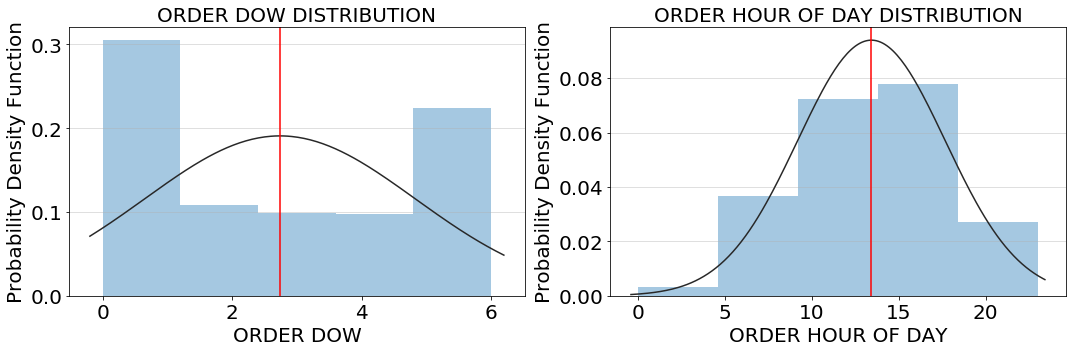

In [54]:
subplot_histograms(full_df, ['order_dow', 'order_hour_of_day'])

- The plot on the left shows the distribution for order day of the week, we can see that most order are placed between Friday and Monday
- The plot on the right shows the distribution for order hour of the day, we can see that more new orders are placed between 9AM - 5PM

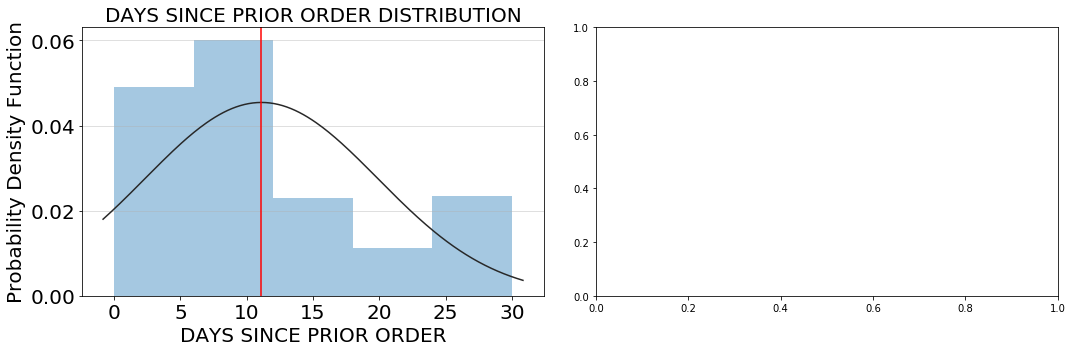

In [55]:
subplot_histograms(full_df, ['days_since_prior_order'])

- The plot above shows the distribution of days since prior order. We can see that most repeated customers will place another order within 12 days after their last order

## Purchasing Behaviour

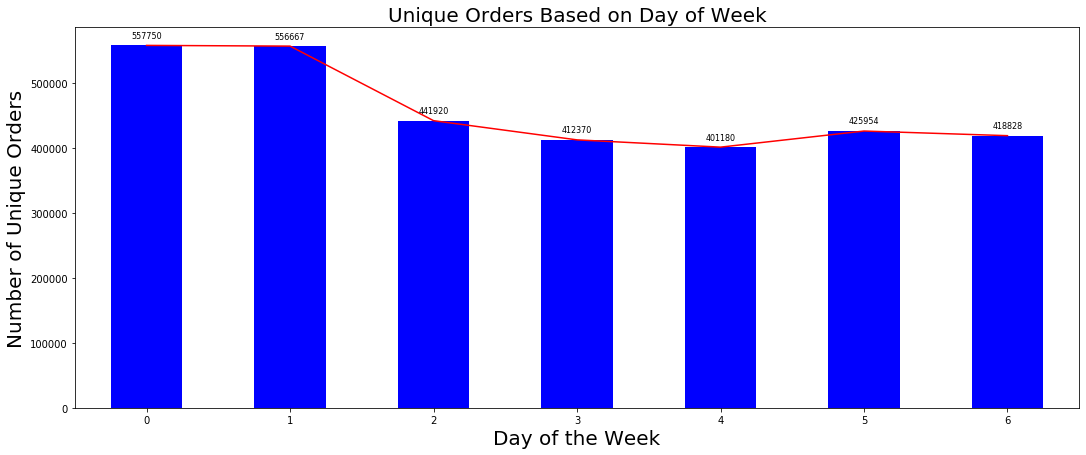

In [56]:
draw_barplot(full_df, 'order_dow', 'order_id', 'Unique Orders Based on Day of Week', xlabel = 'Day of the Week')

- The above plot shows the count of unique orders broken down by the day of the week. It reinforce the information we got from our histogram. Most orders comes in between Sundays and Mondays

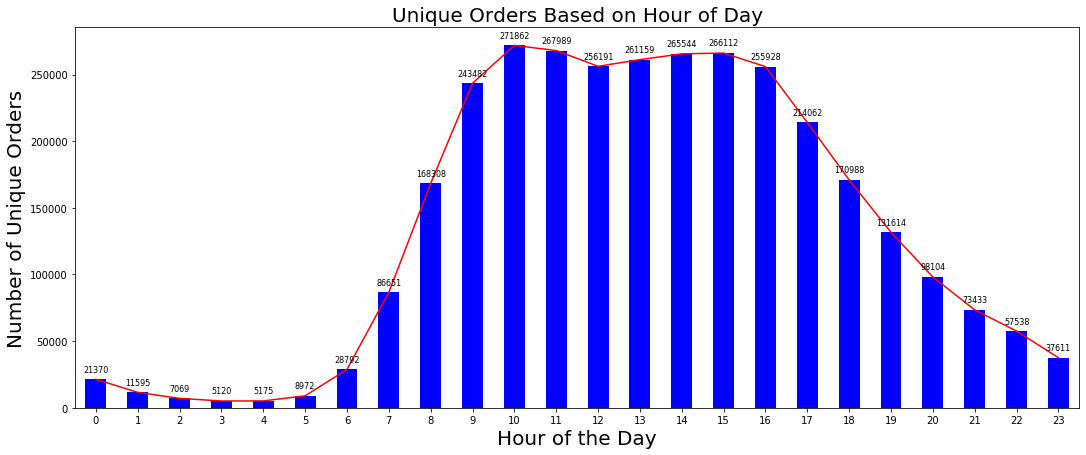

In [57]:
draw_barplot(full_df, 'order_hour_of_day', 'order_id', 'Unique Orders Based on Hour of Day', xlabel = 'Hour of the Day')

- The above plot shows the count of unique orders broken down by the how of day. This too reinforces the information we got from the histogram. Most orders comes in between 9AM to 5PM

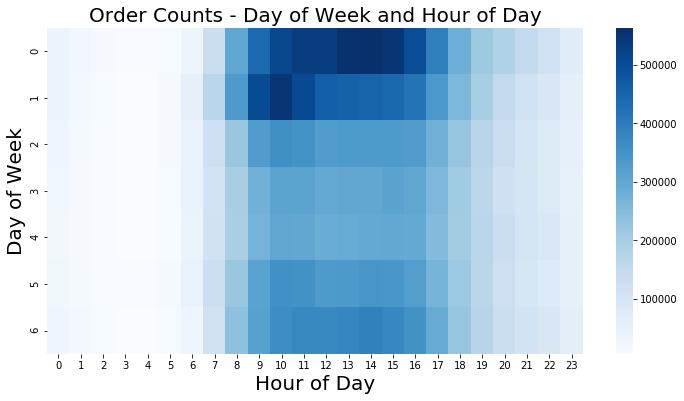

In [58]:
draw_heatmap(full_df, ['order_dow', 'order_hour_of_day'], 'order_number')

- The above heatmap shows the number of orders for day of the week and hour of the day
- We can see that Monday between 9AM to 11AM and Sunday between 9AM to 5PM are when more orders are made
- This reinforces the information we got pertaining to our purchase behaviours so far

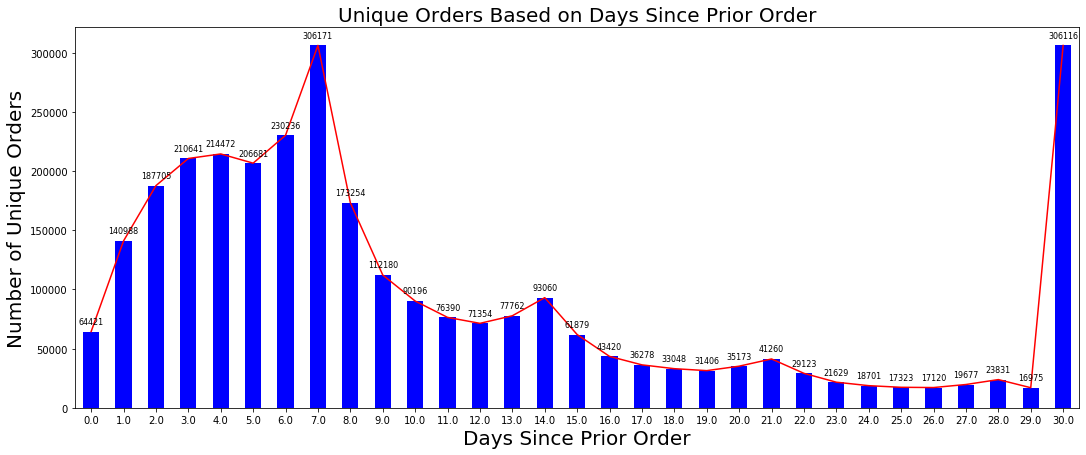

In [59]:
draw_barplot(full_df, 'days_since_prior_order', 'order_id', 'Unique Orders Based on Days Since Prior Order', xlabel = 'Days Since Prior Order')

- From the above plot we can see that there are usually an increase in the number of orders every 7 days
  - There is an increase in day 7 when compared to day 0 to day 7
  - There is an increase in day 14 when compared to day 8 to day 13
  - There is an increase in day 21 when compared to day 15 to day 20
- The 2 peaks are at day 7 and day 30
  - We can infer from this that most of the clients perform grocery shopping on a weekly or a monthly basis
  - Another possibility is that for the spike in day 30 could be for customers who did not place any more orders, customers the organization did not manage to retain
- Another trend we can see is that most of the repeated orders come in within 7 days since the last order

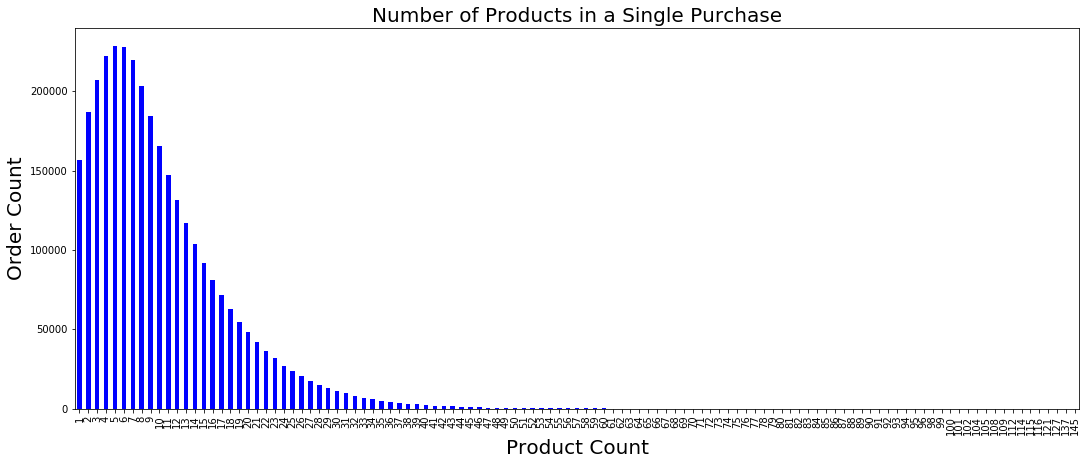

In [60]:
draw_barplot_with_agg(full_df, 'order_id', 'add_to_cart_order', 'Number of Products in a Single Purchase', ylabel = 'Order Count', xlabel = 'Product Count')

- The above plot shows number of products in a single purchase and the number of orders with that product count
- We can see that most clients order between 3 - 10 products on a single purchase.
- __Our recommender system may wish to take this into consideration to calculate how many products to reccomend__

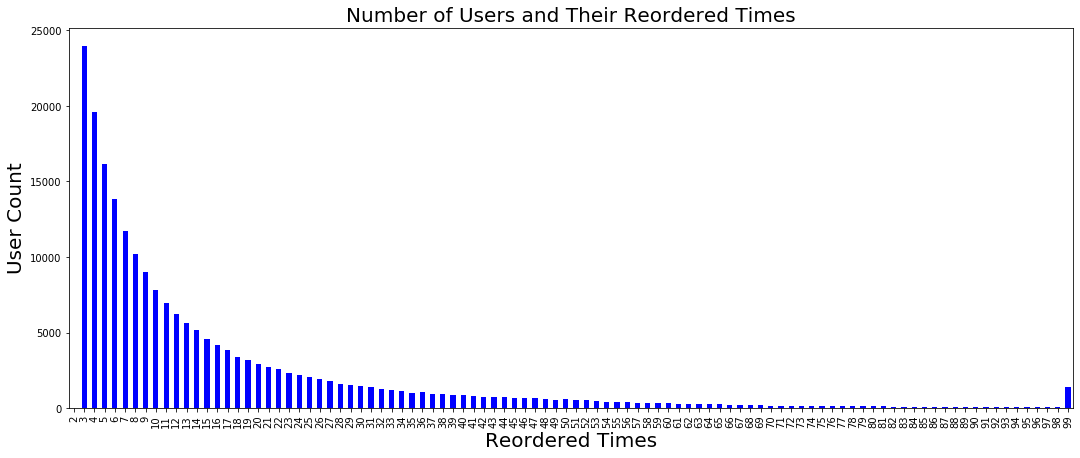

In [61]:
draw_barplot_with_agg(full_df, 'user_id', 'order_number', 'Number of Users and Their Reordered Times', ylabel = 'User Count', xlabel = 'Reordered Times')

- The above plot shows reordered times and the number of clients whom made that number of reorders
- Reordered times are only recorded of for customers who had placed their second order and is only up until the 99th reorders
- We can see we have a group of loyal customers who had reordered for at least 99 times
- We can also see that improvements to customer retention should be explored, as the number of customers decreases as the reordered number increase
- __This information may prove to be useful for customer segmentization (RFM - Recency, Frequency, Monetary) _Frequency___

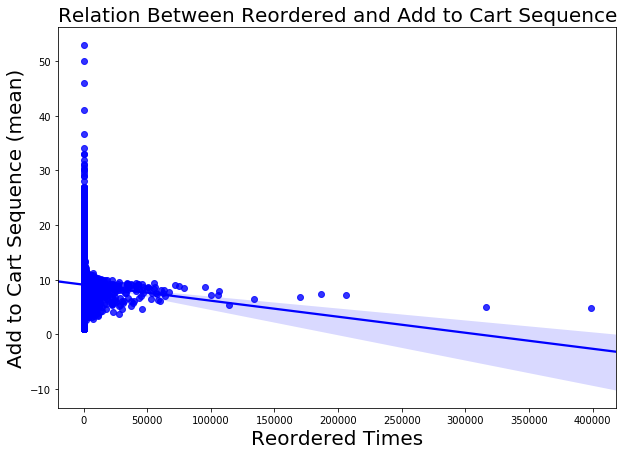

In [62]:
draw_scatter(full_df, 'product_name', ['reordered', 'add_to_cart_order'], 'Relation Between Reordered and Add to Cart Sequence', 'Reordered Times', 'Add to Cart Sequence (mean)')

- The above plot shows the relationship between the sequence a product is added to cart and their reordered times
- A lower value in add to cart means that the product is added to the cart first
- We can see that when the add to cart value is lower, the reordered value shows an increase
- We can determine that products which are added to cart first are more likely to be reordered again
- We can also see that the first 10 products added to cart have a higher chance of being reordered again
- People tends to add items which they will purchase again first, then begin browsing for other products

## Products Insights

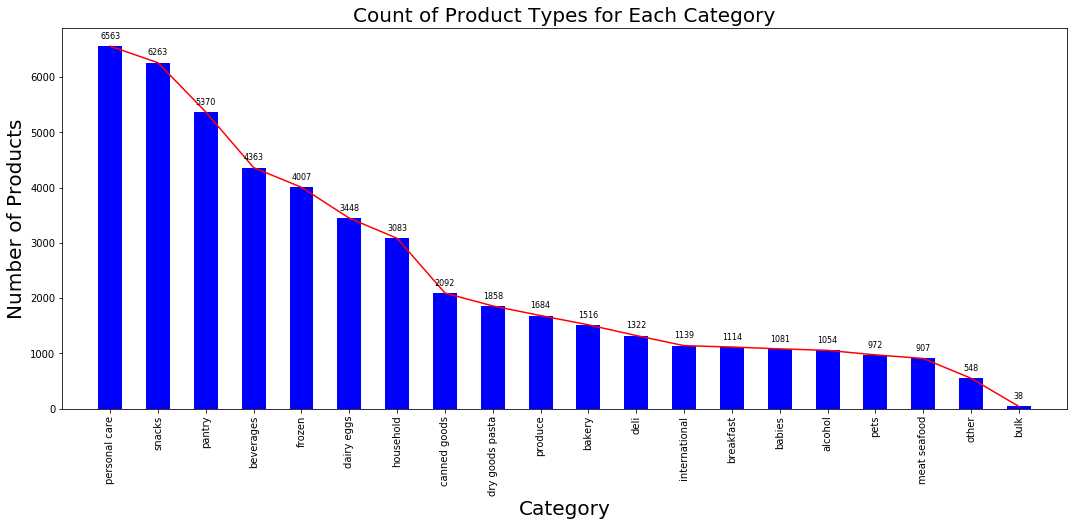

In [63]:
draw_barplot(full_df, 'department', 'product_id', 'Count of Product Types for Each Category', ylabel = 'Number of Products', xlabel = 'Category', rotation = 90, sort = True)

- The above plot shows the categories and the number of unique products they carry
- We can see that personal care carries the most type of products while bulk carries the least

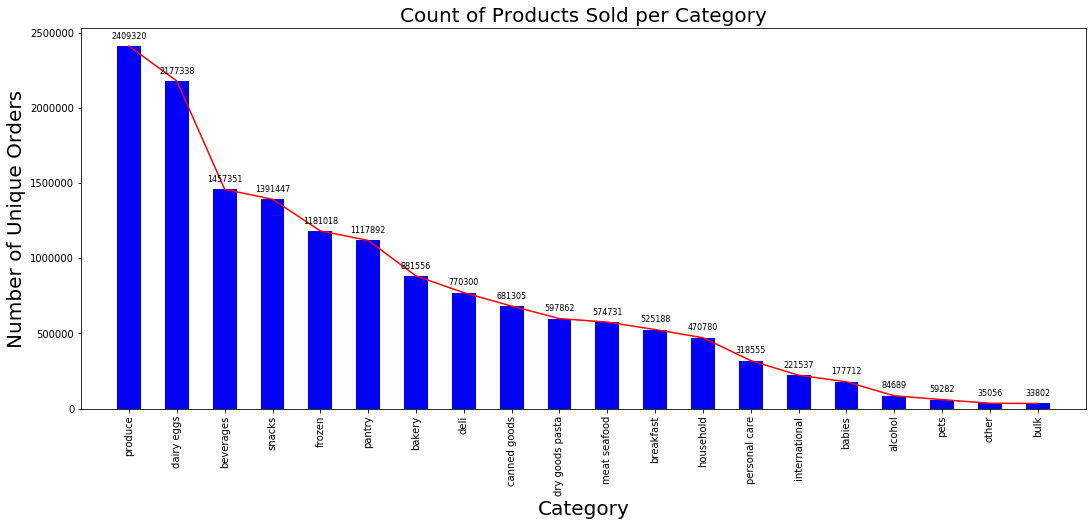

In [64]:
draw_barplot(full_df, 'department', 'order_id', 'Count of Products Sold per Category', xlabel ='Category', rotation = 90, sort = True)

- The above plot shows the top 21 categories of products based on quantity sold.
- The top 3 categories are produce, diary eggs and beverages which are perishable. 
  - Being perishables and non-durable, they have shorter shelf life and requires more frequent replenishing
  - This explains why they clocked the most number of orders 
- Notice that although we carry the most different type of products for personal care, the quantity of its product sold is not the most.
  - At one glance we might think that we should lower the stocks for this categiry, however, this phenomena could be due to products in personal care has a longer shelf life and can be used for a longer period and time, as such do not require frequent replenishing.
  - We should conduct a more indepth look into this category should more data be available to try and uncover more insights

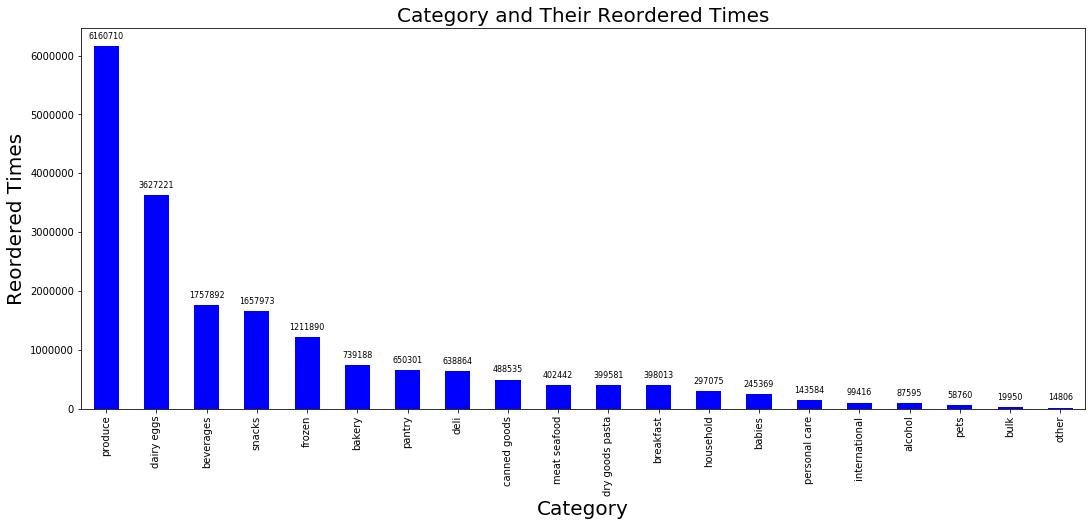

In [65]:
draw_department_reordered(full_df, 'department', 'reordered', 'Category and Their Reordered Times', ylabel = 'Reordered Times', xlabel = 'Category')

- The above plot shows the category and the reordered count of their products
- We can see that the rankings are mostly aligned with the plot showing the count of products sold per category
- We can infer from this that products which are sold more is due to their reorder rate, we can explore more on this

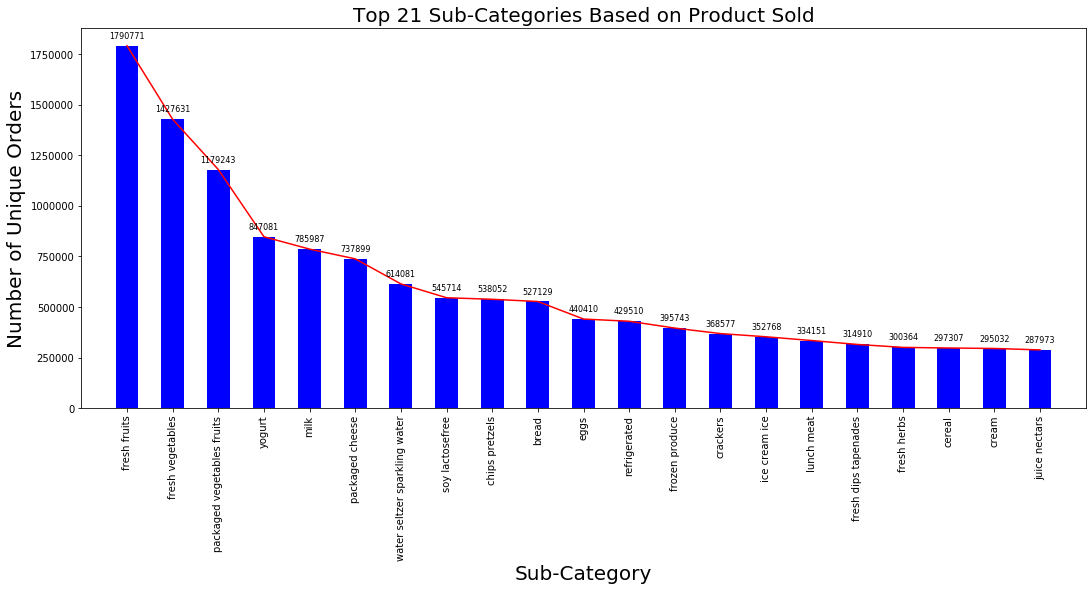

In [66]:
draw_barplot(full_df, 'aisle', 'order_id', 'Top 21 Sub-Categories Based on Product Sold', xlabel ='Sub-Category', rotation = 90, sort = True)

- The above plot shows the top 21 sub-categories which has the most products sold
- The top 3 sub-categories are fresh fruits, fresh vegetabes and packaged vegetables fruits.
- We can see that the top sub-categories consists of all perishable and non-durable.

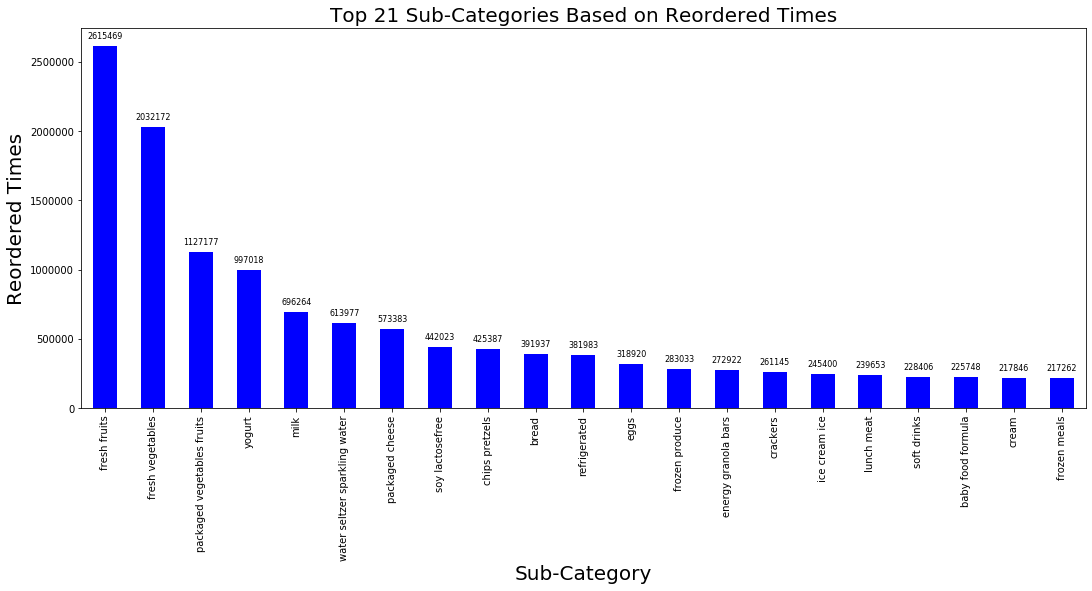

In [67]:
draw_barplot_with_agg_top_21(full_df, 'aisle', 'reordered', 'Top 21 Sub-Categories Based on Reordered Times' , ylabel = 'Reordered Times', xlabel = 'Sub-Category')

- The above plot shows the top 21 sub-categories based on the reordered count of their products
- We can see that this is mostly aligned with the graph showing the top 21 sub-categories based on the count of their products sold
- So far, all we have gathered points to the direction that products which are sold more is due to their re-order rate

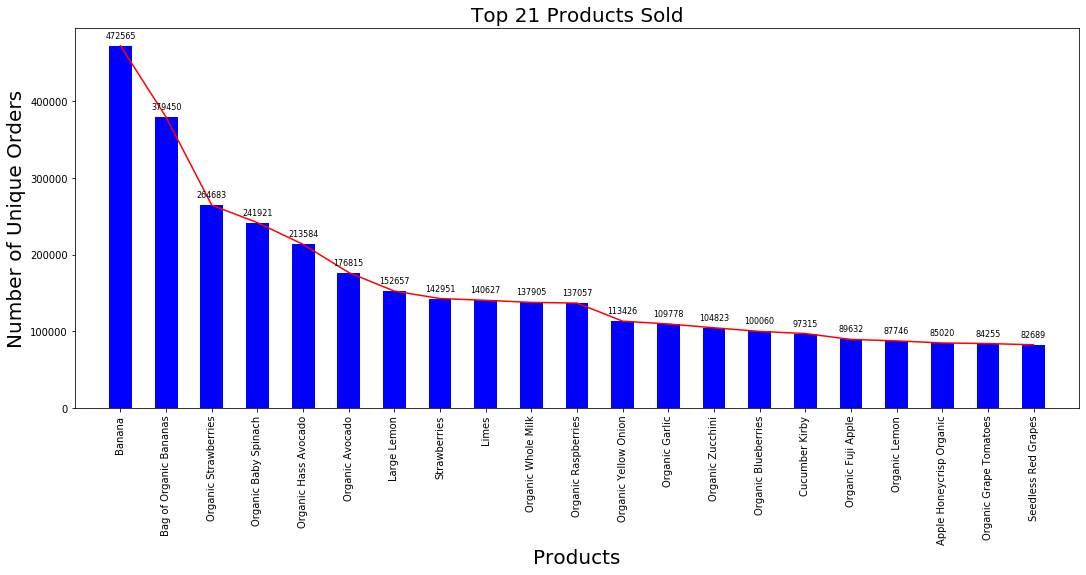

In [68]:
draw_barplot(full_df, 'product_name', 'order_id', 'Top 21 Products Sold', xlabel = 'Products', rotation = 90, sort = True)

- The above shows the top 21 products which has the most quantity sold
- We can see that most of the products are organic products or fruits

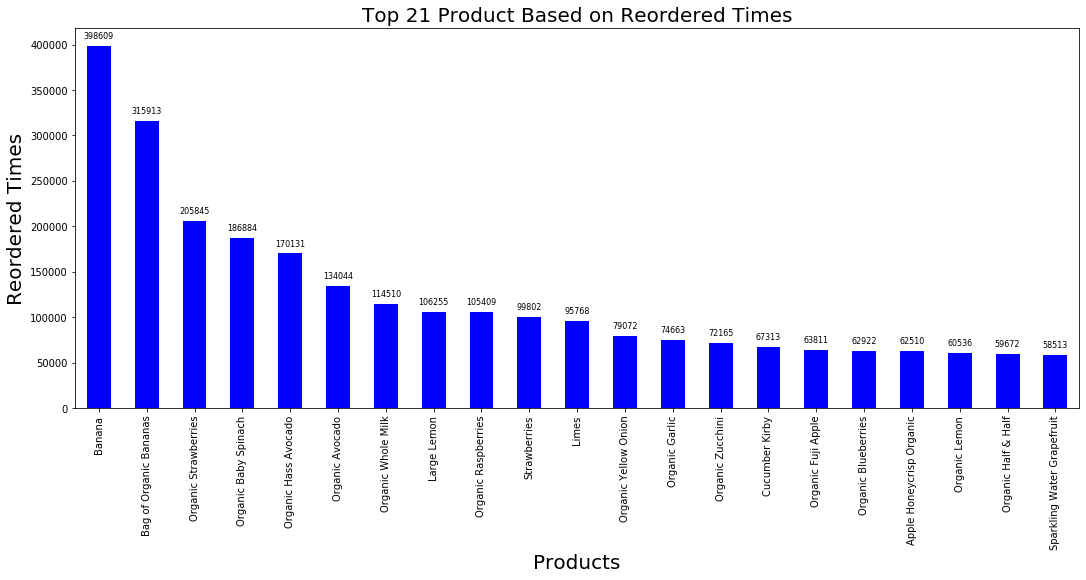

In [69]:
draw_barplot_with_agg_top_21(full_df, 'product_name', 'reordered', 'Top 21 Product Based on Reordered Times' , ylabel = 'Reordered Times', xlabel = 'Products')

- True to our assumption, the top 21 products sold also displayed high reorder count
- From this EDA, we can conclude the following:
  - Mondays between 9AM to 11AM and Sundays between 9AM to 5PM are peak period when most orders are made
  - Most clients purchase between 3 to 10 products in a single order
  - The quantity of products sold is highly influenced by their re-order rate
  - Products added to cart first are more likely to be reordered again
  - Perishables, Organic and Fruits are the top sellers for this organisation
  - The organisation can look into ways to increase customer retention or look into what could have caused the customers to churn

## Correlation